# Data Preparation and Analysis
This Notebook prepares the TIMIT dataset for use with our phoneme discrimination models. It also provides analysis of the data itself, breaking down the number of classes, distribution and so on. 


## SPH to Wav File Converter
The original TIMIT dataset comes in SPH format. We need to convert it to wav for use with our models. Below is our converter. This does not replace the older sph format, but labels our newly produced files as 'converted', as a check that can be used to ensure we have the right files. The original files are kept just in case. 

In [1]:
from sphfile import SPHFile
from pathlib import Path
import glob, os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import statistics 
import math
import librosa
import soundfile as sf
#import sounddevice as sd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm.auto import tqdm

/home/cathaloF/miniconda3/envs/eist/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_split=["./Data/timit/TIMIT/TRAIN/", "./Data/timit/TIMIT/TEST/"]

j=0


#Set up the path
for dialects_path in dataset_split:
    print("Running for %s" %dialects_path)
    #Run through all the dialects
    dialects=os.listdir(path=dialects_path)

    for dialect in dialects:
        print("Converting speakers of dialect %s" %dialect)
        dialect_path = dialects_path + dialect
    
        #Get all the speakers in that dialect
        speakers = os.listdir(path = dialect_path)
        for speaker in speakers:
            speaker_path =  os.path.join(dialect_path,speaker)        
            speaker_recordings = os.listdir(path = speaker_path)

            #Get all the wav files of that speaker
            wav_files = glob.glob(speaker_path + '/*.WAV')

            #Make sure that no converted wavfiles exist BEFORE converting
            n=0
            for wav_file in wav_files:
                if "converted" in wav_file:
                    n+=1
                    #print("x> x> x> Deleting previously converted file, %s" %wav_file)
                    os.remove(wav_file)
                else:
                    continue
            
            #Get all the unconverted files if any had to be deleted
            if n > 0:
                wav_files = glob.glob(speaker_path + '/*.WAV')
                
            #Sanity check - we should always convert 10 files
            assert(len(wav_files)==10)
            
            #Convert all original NIST wav files to true wav files
            for wav_file in wav_files:
                    
                #Read in the OG wav file and print its data
                orig_data, orig_fs=sf.read(wav_file)

                #Name the converted file
                split_path=wav_file.split('/')
                split=split_path[-1].split('.')
                filename="{}_converted.WAV".format(split[0])
                converted=os.path.join(speaker_path, filename)
                #converted="%s/%s_converted.wav" %(speaker_path, split[0])
            
                #Write the newly converted file
                #print("=> => => Writing converted file as %s" %converted)
                sf.write(converted, orig_data, orig_fs)
                
                #Read out the new wav file and print its data
                data, fs=librosa.load(converted, sr=None)
                
                #Assert that we did not change the data shape or sampling rate
                assert(data.shape == orig_data.shape)
                assert(fs== orig_fs)
                
                #Make sure that the written converted file indeed exists
                converted_file=Path(converted)
                assert(converted_file.is_file())
                
                j+=1
            
     
            wav_files = glob.glob(speaker_path + '/*.WAV')
            #Sanity check - there should now be 20 wav files, 10 original and 10 converted
            assert(len(wav_files)==20)
            

#Sanity check - make sure we converted the correct number of files           
assert(j==6300)
print("Converted %d files overall" %j)

Running for ./Data/timit/TIMIT/TRAIN/
Converting speakers of dialect DR6
Converting speakers of dialect DR7
Converting speakers of dialect DR3
Converting speakers of dialect DR4
Converting speakers of dialect DR2
Converting speakers of dialect DR8
Converting speakers of dialect DR5
Converting speakers of dialect DR1
Running for ./Data/timit/TIMIT/TEST/
Converting speakers of dialect DR6
Converting speakers of dialect DR7
Converting speakers of dialect DR3
Converting speakers of dialect DR4
Converting speakers of dialect DR2
Converting speakers of dialect DR8
Converting speakers of dialect DR5
Converting speakers of dialect DR1
Converted 6300 files overall


All files should now be converted to a usable format.

## Data Analysis
The purpose of our data analysis is to understand the distribution present in our data. This should help us identify any issues that may arise with the learning of our models. 

First, we will just confirm the size of each of our data splits and subtypes; number of dialects used, number of speakers and the amount of sentences spoken in our data split and overall.

### Dataset Description

In [3]:
dataset_split=["./Data/timit/TIMIT/TRAIN/", "./Data/timit/TIMIT/TEST/"]

dataset={"./Data/timit/TIMIT/TRAIN/":"Train", "./Data/timit/TIMIT/TEST/": "Test"}

total_speakers=0
total_dialects=0
total_sentences=0
total_duration=0

for dialects_path in dataset_split:

    num_speakers=0
    num_sentences=0
    set_duration=0

    #Run through all the dialects
    dialects=os.listdir(path=dialects_path)

    for dialect in dialects:
        dialect_path = dialects_path + dialect
    
        #Get all the speakers in that dialect
        speakers = os.listdir(path = dialect_path)
        num_speakers=num_speakers+len(speakers)
          
        for speaker in speakers:
            speaker_path =  os.path.join(dialect_path,speaker)        
            speaker_recordings = os.listdir(path = speaker_path)

            #Get all the wav files of that speaker
            wav_files = glob.glob(speaker_path + '/*_converted.WAV')
            
            for wav_file in wav_files:
                audio_data, fs=librosa.load(wav_file, sr=16000)
               
                duration=len(audio_data)/fs
                
                set_duration+=duration
           
            num_sentences+=len(wav_files)
        
    total_speakers+=num_speakers
    total_dialects+=len(dialects)
    total_sentences+=num_sentences
    total_duration+=set_duration
          
    
    print("***%s Dataset Summary: %d Dialects, %d Speakers and %d Sentences, Duration %d***" \
          %(dataset[dialects_path], len(dialects), num_speakers, num_sentences, int(set_duration/60)))
    
    
print("======================================================================================================")
print("***** Total Data Summary: %d Dialects, %d Speakers, %d Sentences and %d Minutes \
in the overall original Dataset *****" \
          %(total_dialects, total_speakers, total_sentences, int(total_duration/60)))

***Train Dataset Summary: 8 Dialects, 462 Speakers and 4620 Sentences, Duration 236***
***Test Dataset Summary: 8 Dialects, 168 Speakers and 1680 Sentences, Duration 86***
***** Total Data Summary: 16 Dialects, 630 Speakers, 6300 Sentences and 322 Minutes in the overall original Dataset *****


This data summary matches the readme given with the TIMIT dataset. Now we should delve into the more granular data details - phoneme label distribution and count. 

There are 61 phoneme mappings in TIMIT - but the differences between some are minimal. Copying prior experimentation methodology, we will map the 61 phonemes to 39 phonemes, which shall be the ones we will actually try to predict using our models.

In [4]:
 #TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

In [5]:

dataset_split=["./Data/timit/TIMIT/TRAIN/", "./Data/timit/TIMIT/TEST/"]

dataset={"./Data/timit/TIMIT/TRAIN/":"Train", "./Data/timit/TIMIT/TEST/": "Test"}

#This will hold all the phonemes discovered 
phoneme_df=pd.DataFrame(columns=["Phoneme", "Count", "Max Length", "Min Length", \
                                       "Total Length", "Train Count", "Test Count"])

#This will give a list of all the phoneme lengths
lengths=[]
phoneme_lengths=[]

#Go through the two datasets
for dialects_path in dataset_split:
    print("Running for %s" %dialects_path)
    
    #Run through all the dialects
    dialects=os.listdir(path=dialects_path)

    for dialect in dialects:
        print("Building phoneme dataframe for speakers of dialect %s" %dialect)
        dialect_path = dialects_path + dialect
    
        #Get all the speakers in that dialect
        speakers = os.listdir(path = dialect_path)
          
        for speaker in speakers:
            speaker_path =  os.path.join(dialect_path,speaker)        
            speaker_recordings = os.listdir(path = speaker_path)

            #Get all the phoneme files of that speaker
            phn_files = glob.glob(speaker_path + '/*.PHN')

            #Get the phoneme transcript for each phoneme file
            for phn_file in phn_files:
                #Go through all the lines in the file
                file=open(phn_file, 'r')
                
                for line in file:
                    #Get the beginning, end and phoneme
                    info=line.split(" ")
                
                    begin=int(info[0])
                    end=int(info[1])
                    phoneme=info[2].rstrip()
                    #Change the phoneme mappings
                    phoneme=phon61_map39[phoneme]
                    
                    length=end-begin
                
                    lengths.append(length)
                    
                    #This only gets the length of real phonemes - start and trailing silences
                    #don't count
                    if phoneme != 'h#':
                        phoneme_lengths.append(length)
                    
                    #Check if the phoneme is in the dataframe - add it if not, increment the count if so
                    if( phoneme_df==phoneme).any().any():
                        #print("Phoneme %s already exists in the dataframe, incrementing count" %phoneme)
                    
                        dataset_type="%s Count" % dataset[dialects_path]
                        phoneme_df.loc[phoneme_df["Phoneme"] == phoneme, dataset_type]+=1
                        phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Count']+=1
                        count=phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Count'].values[0]
                    
                        maximum=phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Max Length'].values[0]
                        minimum=phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Min Length'].values[0]
                        phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Max Length']= max(length, maximum)
                        phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Min Length']= min(length, minimum)
                        phoneme_df.loc[phoneme_df['Phoneme'] == phoneme, 'Total Length']+=length
                        
                        
                    else:
                        #print("Phoneme %s does not exist in the dataframe, adding it" %phoneme)
                    
                        phoneme_dict={'Phoneme': phoneme, 'Count':1, 'Max Length':length, \
                                 'Min Length':length, 'Total Length':length, \
                                      'Train Count':0, 'Test Count':0}
                    
                        phoneme_df = phoneme_df._append(phoneme_dict, ignore_index = True)
                        
                        #Increase the count by one of whatever dataset it was found in
                        dataset_type="%s Count" % dataset[dialects_path]
                        phoneme_df.loc[phoneme_df["Phoneme"] == phoneme, dataset_type]+=1
                        
                        
    #Print the phoneme distribution for this dataset
    print(phoneme_df)


    
unique_phone=phoneme_df['Phoneme'].unique()
#Calculate the average phoneme length
#phoneme_df['Avg Length']=phoneme_df["Total Length"]/phoneme_df['Count']
#phoneme_df

Running for ./Data/timit/TIMIT/TRAIN/
Building phoneme dataframe for speakers of dialect DR6
Building phoneme dataframe for speakers of dialect DR7
Building phoneme dataframe for speakers of dialect DR3
Building phoneme dataframe for speakers of dialect DR4
Building phoneme dataframe for speakers of dialect DR2
Building phoneme dataframe for speakers of dialect DR8
Building phoneme dataframe for speakers of dialect DR5
Building phoneme dataframe for speakers of dialect DR1
   Phoneme  Count Max Length Min Length Total Length Train Count Test Count
0       h#  39467      47950         32     58176553       39467          0
1        w   3140       3462        152      3346294        3140          0
2       eh   3853       4498        343      5622457        3853          0
3        n   8762       3397        122      7518425        8762          0
4       hh   2111       4000        220      2260281        2111          0
5       iy   6953       6851        372     10059320        6953  

## Data Summary: Visualisations
Now that we have a handy dataframe that describes our data, and a list containing all the phoneme lengths, we can move on to visualize this information. This should allow us to better understand the data itself, and the differences in distribution between the train and test sets.

We want to:
- Understand how long phonemes last, and the distribution that their length takes
- Understand the different classes of phonemes and their distribution in the dataset
- Understand how that distribution of phoneme classes differs between the test and train set

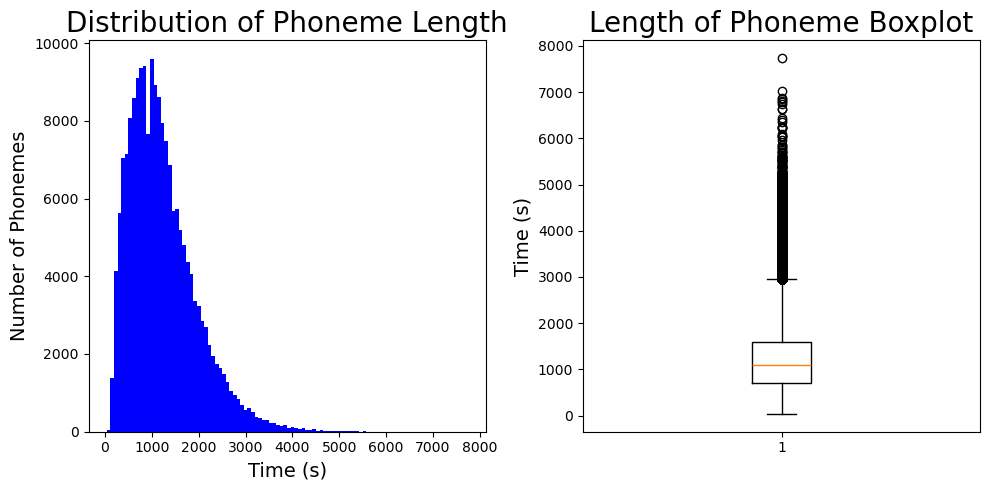

In [6]:
#Change the lengths list into a lengths array
lengths=np.array(phoneme_lengths)

fig, (ax, ax1)=plt.subplots(1, 2, figsize=(10, 5))
    
#Plot the histogram distribution
ax.hist(lengths, color="blue", bins=100)
    
# Title and labels
ax.set_title('Distribution of Phoneme Length', size=20)
ax.set_xlabel("Time (s)", size = 14)
ax.set_ylabel('Number of Phonemes', size= 14)

ax1.boxplot(lengths)
ax1.set_title("Length of Phoneme Boxplot", size=20)
ax1.set_ylabel("Time (s)", size=14)

plt.tight_layout()
plt.show()

So phonemes clearly follow a power law distribution, with mos

In [7]:

print("The given phoneme lengths have: \nMaximum : %d \nMinimum : %d \nAverage : %f \nMedian : %d \nFirst quartile : %d \
\nThird Quartile : %d" %(max(lengths), min(lengths), sum(lengths)/len(lengths), \
          np.median(lengths), np.quantile(lengths, .25), np.quantile(lengths, .75)))

length_table={"Maximum": lengths.max(), "Minimum": lengths.min(), \
              "Average": lengths.mean(), "Median":np.median(lengths), \
             "First Quartile" : np.quantile(lengths, .25),
              "Third Quartile": np.quantile(lengths, .75)}

length_df=pd.DataFrame(pd.Series(length_table))

The given phoneme lengths have: 
Maximum : 7735 
Minimum : 36 
Average : 1227.150572 
Median : 1087 
First quartile : 699 
Third Quartile : 1602


In [8]:
length_df.T

,Maximum,Minimum,Average,Median,First Quartile,Third Quartile
0,7735.0,36.0,1227.150572,1087.0,699.0,1602.0


[]

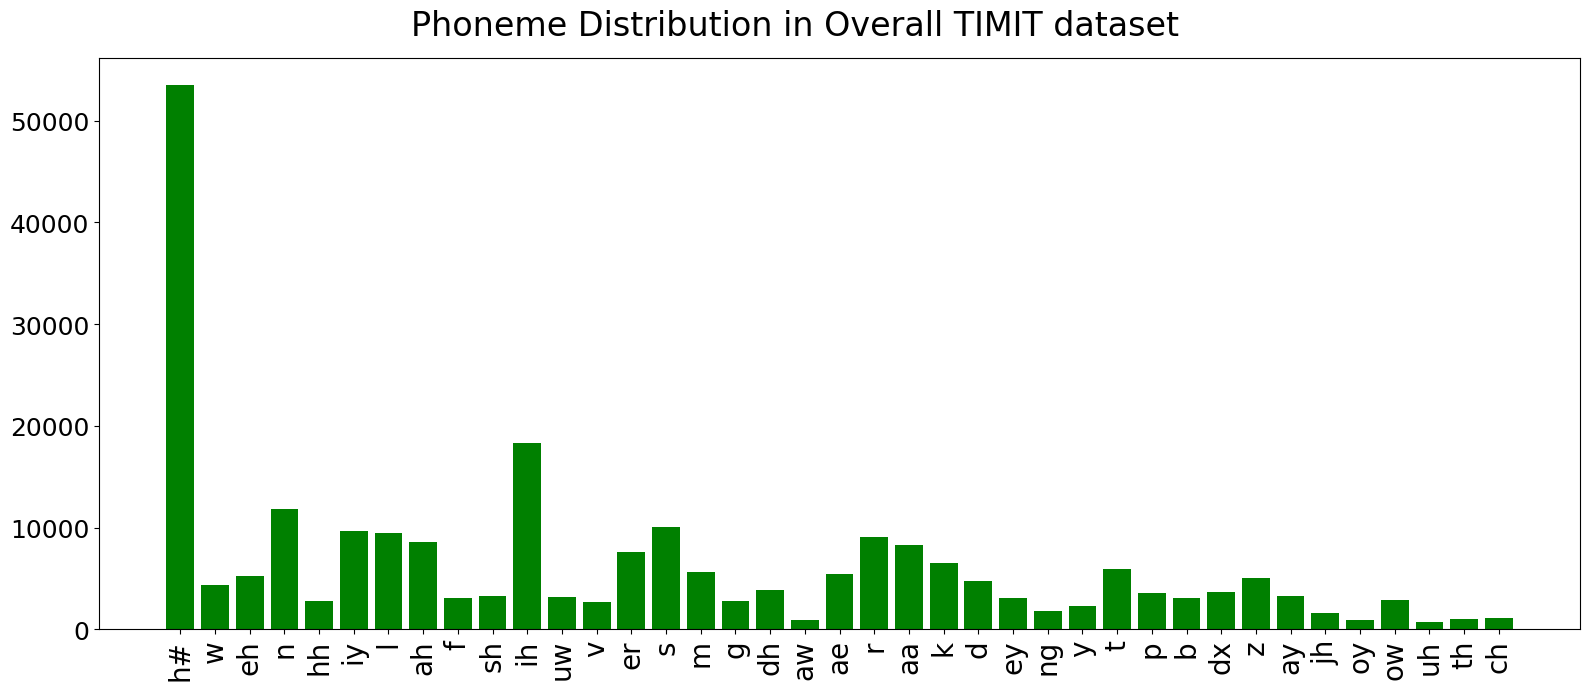

In [9]:
fig=plt.figure(figsize=(16, 7))

fig=plt.bar(phoneme_df['Phoneme'], phoneme_df['Count'], color="Green")

plt.xticks(fontsize=20, rotation=90)
plt.yticks(fontsize=18)
plt.suptitle('Phoneme Distribution in Overall TIMIT dataset', fontsize=24)
plt.tight_layout()
plt.plot()

[]

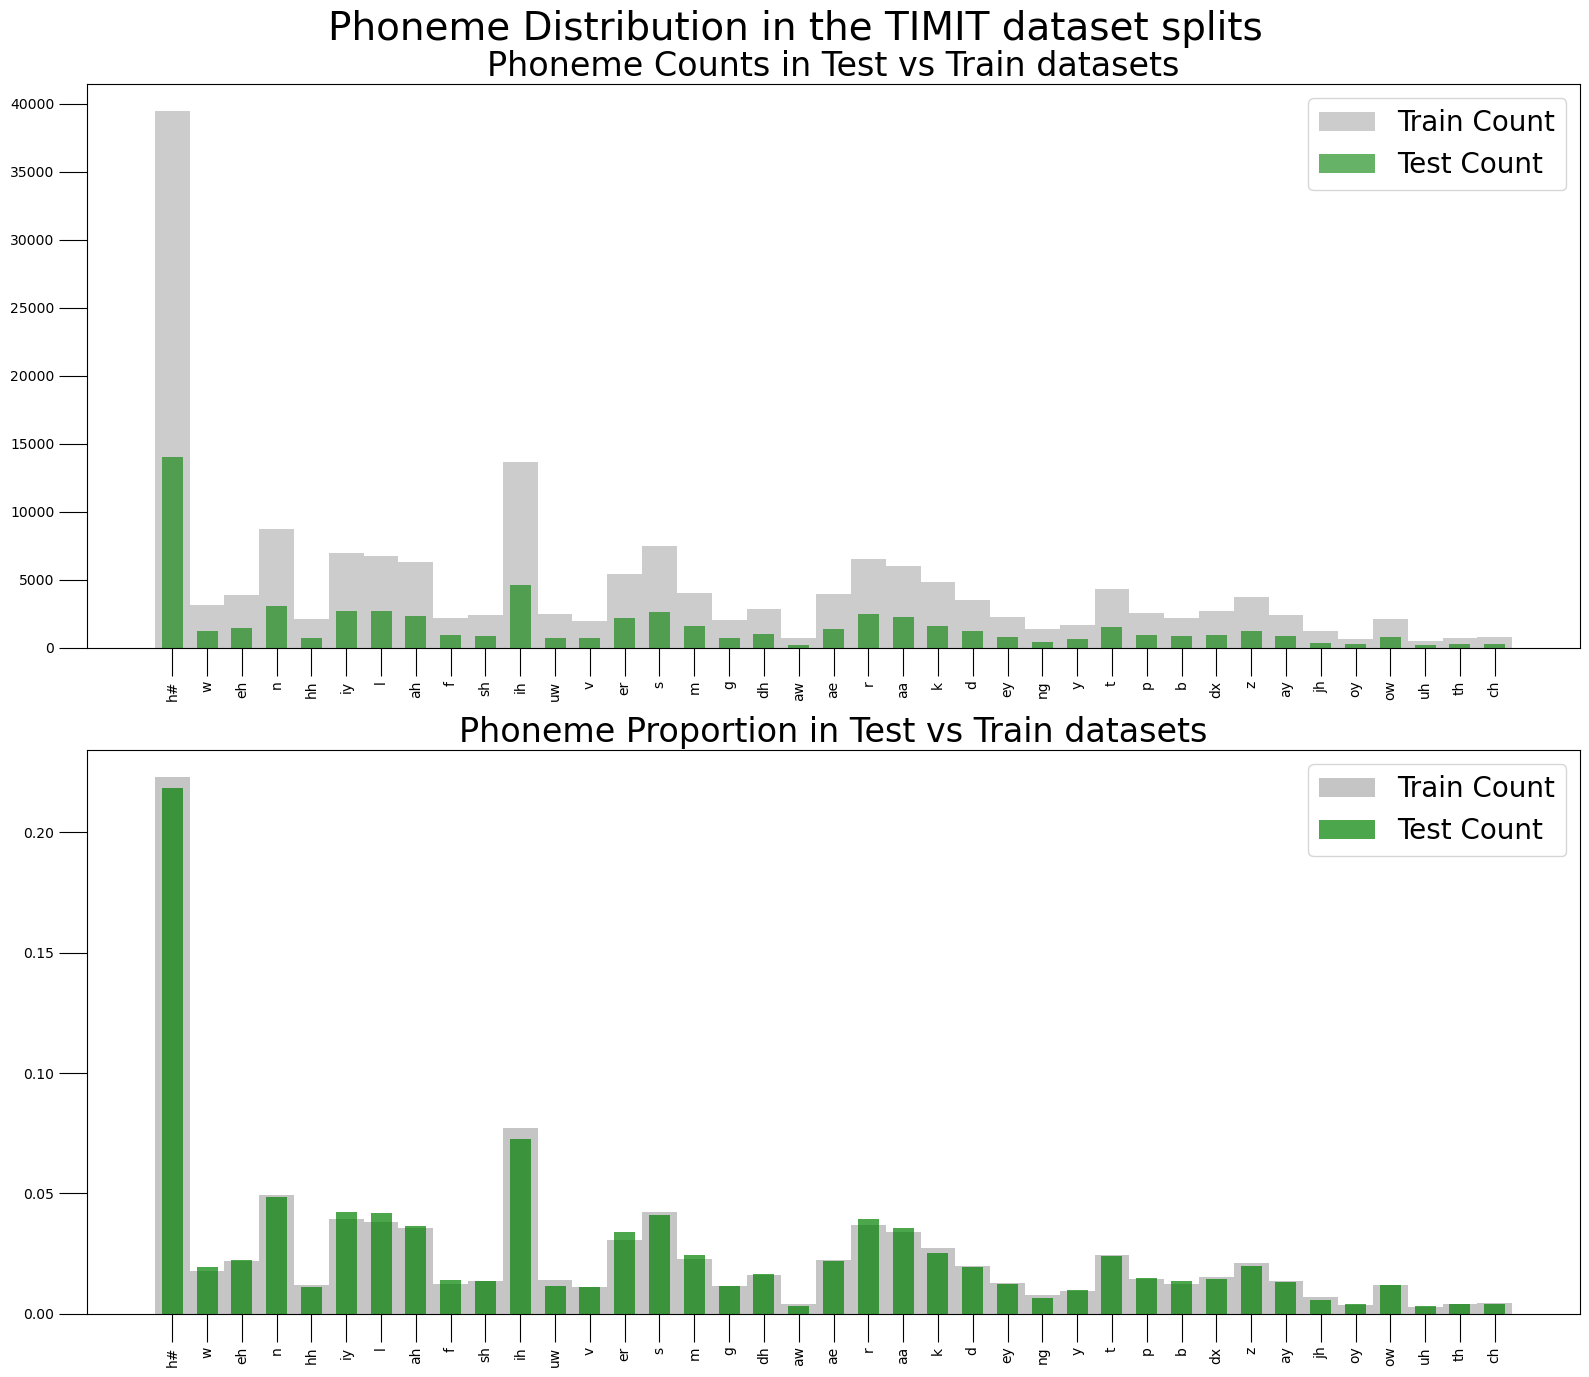

In [10]:
fig, (ax, bx)=plt.subplots(nrows=2, figsize=(16, 14))

ax.bar(phoneme_df['Phoneme'], phoneme_df['Train Count'], width=1, color="Grey", alpha=0.4, label='Train Count')
ax.bar(phoneme_df['Phoneme'], phoneme_df['Test Count'], width=0.6, color="Green", alpha=0.6, label='Test Count')

ax.tick_params(axis='x', rotation=90, size=20)
ax.tick_params(axis='y',  size=20)
ax.set_title('Phoneme Counts in Test vs Train datasets', fontsize=24)
ax.legend(fontsize=20)

train_counts=phoneme_df['Train Count'].sum()
test_counts=phoneme_df['Test Count'].sum()

bx.bar(phoneme_df['Phoneme'], phoneme_df['Train Count']/train_counts, \
        width=1, color="Grey", alpha=0.45, label='Train Count')
bx.bar(phoneme_df['Phoneme'], phoneme_df['Test Count']/test_counts, \
        width=0.6, color="Green", alpha=0.7, label='Test Count')

bx.tick_params(axis='x', rotation=90, size=20)
bx.tick_params(axis='y',  size=20)
bx.set_title('Phoneme Proportion in Test vs Train datasets', fontsize=24)
bx.legend(fontsize=20)

fig.suptitle('Phoneme Distribution in the TIMIT dataset splits', fontsize=28)
plt.tight_layout()
plt.plot()

This shows us that the distribution isn't all that different from the overall distribution - they have extremely similar proportional splits, especially given the fact that they are built using completely separate sentences. This is also seen in the way that the phoneme count histogram has the same shape for the two datasets.

Phonemes are amongst the smallest speech features - but they are not the only. Next steps is to analyse our data to understand what speaker information is held. We want to know:

- The split for dialects 
- The number of speakers per dialect

# Output Y : Phoneme Sample Rater
Before use, we will need a dataset that gives out a phoneme label for every 10ms. This is based on the sample rate of the classifier, which itself is based on the sample rate used by APC and CPC. 

The phoneme files (.phn) give what phoneme occurs at what sample index. We want to read this, generate a phoneme label every 10ms that corresponds to the current phoneme, and store this output in a csv file for simplicities sake. This can then be used by the torch dataset in the next jupyter notebook.

In [11]:
print(len(unique_phone))

#Sort and save the unique phonemes
unique_phone.sort()
uniques=pd.DataFrame(unique_phone)
uniques.set_index(0, inplace=True)
uniques.rename_axis(index='Phoneme', inplace=True)
uniques.to_csv("Data/Phoneme_List.csv")

out_file=Path("Data/Phoneme_List.csv")
assert(out_file.is_file())

uniques

39


""
Phoneme
aa
ae
ah
aw
ay
b
ch
d
dh


In [12]:
unique_phonemes=pd.read_csv("Data/Phoneme_List.csv")
corrects=np.zeros(39)
totals=np.zeros(39)
unique_phonemes['Correct']=corrects
unique_phonemes['Total']=totals
unique_phonemes

,Phoneme,Correct,Total
0,aa,0.0,0.0
1,ae,0.0,0.0
2,ah,0.0,0.0
3,aw,0.0,0.0
4,ay,0.0,0.0
5,b,0.0,0.0
6,ch,0.0,0.0
7,d,0.0,0.0
8,dh,0.0,0.0
9,dx,0.0,0.0


In [13]:
def wav2vec2_sr(signal):
    """
    This function takes the signal as input, and computes how many samples the wav2vec2 model
    would compute for the signal. This can then be used to sample the phn file to figure out what 
    the phoneme values are for each sample.
    
    Input: Signal : (Time, num_channels)
    Output: Lout (number of samples output by wav2vec2)
    """
    sigLen=len(signal)
    
    #These are the kernel and stride values for default wav2vec2
    kernels=[10, 3, 3, 3, 3, 2, 2]
    strides=[5, 2, 2, 2, 2, 2, 2]
    
    
    Lin=sigLen
    Lout=0
    
    #Calculate how much the convolutions will downsample by
    for k, s in zip(kernels, strides):
        #Formula: Lout= math.floor((Lin - K + 2*P)/s +1 )
        #K = kernel size, P = padding size 
        Lout=math.floor(((Lin-k+2*(0))/s) +1)
        
        Lin=Lout
        
    return Lout

In [14]:
def mel_sr(signal, nfft=0.025, hop_length=0.01, fs=16000):
    """
    This function takes the signal as input, and computes how many samples a mel spectrogram model
    would compute for the signal. This can then be used to sample the phn file to figure out what 
    the phoneme values are for each sample.
    
    Input: Signal : (Time, num_channels)
    Output: Num_mels (number of samples output by mel spectrogram transformations)
    """
    sigLen=len(signal)
    frame_length=nfft*fs
    hop_length=hop_length*fs
    
    #Formula n_frames = 1 + int(((len(signal) +frame_length) - frame_length) / hop_length)
    #The additional size is due to zero padding of the signal, so that the mel spectrograms are centered
    n_mels=int((sigLen+frame_length -frame_length)/hop_length)+1
    
    return n_mels

In [15]:
def whisper_sr(signal, nfft=0.025, hop_length=0.01, fs=16000):
    """
    This function takes the signal as input, and computes how many samples Whisper 
    would compute for the signal. This can then be used to sample the phn file to figure out what 
    the phoneme values are for each sample.
    
    Input: Signal : (Time, num_channels)
    Output: Num_whisper (number of samples output by whisper encoders)
    """
    n_mels=mel_sr(signal, nfft, hop_length, fs)

    #These are the kernel and stride values for default whisper
    kernels=[3, 3]
    strides=[1, 2]
    
    
    Lin=n_mels
    Lout=0
    
    #Calculate how much the convolutions will downsample by
    for k, s in zip(kernels, strides):
        #Formula: Lout= math.floor((Lin - K + 2*P)/s +1 )
        #K = kernel size, P = padding size 
        Lout=math.floor(((Lin-k+2*(1))/s) +1)
        
        Lin=Lout
        
    return Lout

In [19]:
dataset_split=["./Data/timit/TIMIT/TRAIN/", "./Data/timit/TIMIT/TEST/"]

dataset={"./Data/timit/TIMIT/TRAIN/":"Train", "./Data/timit/TIMIT/TEST/": "Test"}

#Keep count on how many files we've converted overall
j=0


#Keep track of the phoneme classes
cat_type = CategoricalDtype(categories=unique_phone, ordered=True)
phoneme_class_dict={}
n_unique=0

#Go through the two datasets
for dialects_path in dataset_split:
    print("Running for %s" %dialects_path)
    
    #Run through all the dialects
    dialects=os.listdir(path=dialects_path)

    for dialect in dialects:
        print("Building phoneme output CSVs for speakers of dialect %s" %dialect)
        dialect_path = dialects_path + dialect
    
        #Get all the speakers in that dialect
        speakers = os.listdir(path = dialect_path)
          
        for speaker in speakers:
            speaker_path =  os.path.join(dialect_path,speaker)        
            speaker_recordings = os.listdir(path = speaker_path)
            
            #Get all the previously made csv files of that speaker
            csv_files = glob.glob(speaker_path + '/*.csv')
            #Make sure that no csv files exist for each speaker BEFORE creating
            n=0
            for csv_file in csv_files:
                os.remove(csv_file)
                n=n+1

            #Get all the phoneme files of that speaker
            phn_files = glob.glob(speaker_path + '/*.PHN')

            #Get the phoneme transcript for each phoneme file
            for phn_file in phn_files:
                
                #Get the filestem
                split_path=phn_file.split('/')
                split=split_path[-1].split('.')
                filestem=split[0]
                
                #Load in the corresponding audio file
                audio_file=speaker_path + "/" + filestem + "_converted.WAV"
                signal, sr= librosa.load(audio_file, sr=None)
                
                #WavIHC discards the first 2047 samples, starts on 2048 - build that into outputs
                for i in range(2):
                    
                    #This holds the time difference between samples taken. This is given in the two time frequencies, that used 
                    #by cpc & apc, and that used by wav2vec2
                    Sampling_Rates=[]
                    Sample_dict={}
                    #Calculate the wav2vec2 sampling rate, it should always be approximately 20ms
                    #IHC alternatives
                    if i==0:
                        #CPC sampling
                        Sampling_Rates.append(math.floor(len(signal)/160))
                        Sample_dict[Sampling_Rates[0]]=160
                        #Mel sampling
                        Sampling_Rates.append(mel_sr(signal))
                        Sample_dict[Sampling_Rates[1]]=160
                        #Wav2vec2 sampling
                        Sampling_Rates.append(wav2vec2_sr(signal))
                        Sample_dict[Sampling_Rates[2]]=math.ceil(len(signal)/Sampling_Rates[2])
                        #Whisper sampling
                        Sampling_Rates.append(whisper_sr(signal))
                        Sample_dict[Sampling_Rates[3]]=math.ceil(len(signal)/Sampling_Rates[3])
                    #IHC models
                    else:
                        #CPC sampling
                        Sampling_Rates.append(math.floor((len(signal)-2047)/160))
                        Sample_dict[Sampling_Rates[0]]=160
                        #Mel sampling
                        Sampling_Rates.append(mel_sr(signal[2047:]))
                        Sample_dict[Sampling_Rates[1]]=160
                        #Wav2vec2 sampling
                        Sampling_Rates.append(wav2vec2_sr(signal[2047:]))
                        Sample_dict[Sampling_Rates[2]]=math.ceil((len(signal)-2047)/Sampling_Rates[2])
                    
                    #Sample the files at the required rates
                    for sampler_idx, TIME_DIF in enumerate(Sampling_Rates):
                        
                        #Go through all the lines in the file
                        file=open(phn_file, 'r')
                    
                        #Get the frequency for the sampling rate, with a sampling rate of 16k 
                        #distance between samples, should be 16 given
                        sampling_freq=Sample_dict[TIME_DIF]
                        num_samples_remaining=TIME_DIF
                
                
                        #Get how much time has progressed as we loop through the sample
                        if i==0:
                            time=0
                        else:
                            time=2047
                
                        #This will hold the label object, which will store label, time pairs as well as the label list
                        label={}
                        label_list=[]
                        start_flag=False
                        boundary_previous=0
                        boundary_now=0
                        previous_phoneme='h#'
                            
                            
                        #Loop through the file
                        for a, line in enumerate(file):
                            if a != 0:
                                #Get how much of the sample is the previous phoneme
                                previous_phoneme=phoneme
                                boundary_previous=end-time
                            
                            #Get the beginning, end and phoneme
                            info=line.split(" ")
                    
                            begin=int(info[0])
                            end=int(info[1])
                            phoneme=info[2].rstrip()
                            
                            #Change the phoneme mappings
                            phoneme=phon61_map39[phoneme]
                            
                            #If we're out here, we're at a phoneme boundary - keep track of how much of the 
                            #Thing is what type of phoneme
                            boundary_previous=time
                            
                            #Loop time until it exceeds the phoneme length
                            #While the time is between the phoneme end and beginning, after the first phoneme
                            #Which should be silence, and the documentation says it is unlikely to begin at 0
                            while(time<end):
                                
                                num_samples_remaining-=1                             
                                if(num_samples_remaining<0):
                                    break
                                        
                                #If time is less than the begin at the start of the frame, then the phoneme is a boundary
                                if(time <begin):
                                    #Take the phoneme that is the majority of the samples
                                    boundary_next=math.ceil(sampling_freq-boundary_previous)
                                    
                                    if (boundary_next < boundary_previous):
                                        phoneme=previous_phoneme
                                    
                                #Check if it's a new phoneme - if so, give it a class label
                                if phoneme not in phoneme_class_dict:
                                    phoneme_class_dict[phoneme]=n_unique
                                    n_unique+=1
                        
                                #Add the phoneme label to the records and reset label
                                label['Phoneme']=phoneme
                                label['Frame']=time
                                label_list.append(label)
                                label={}
                                
                                #Increment. Make sure that time is always an int, by always rounding up
                                time+=sampling_freq
                        
                        if (num_samples_remaining > 0):
                            while(time <= len(signal)):
                                num_samples_remaining-=1                    
                                if(num_samples_remaining<0):
                                    break
                                    
                                #Add trailing silence
                                label['Phoneme']='h#'
                                label['Frame']=time
                                label_list.append(label)
                                label={}
                        
                                time+=sampling_freq   
                        
                        error=False
                        #If there is any samples left, which may be due to padding - give them the final value
                        while num_samples_remaining >0 :
                            num_samples_remaining-=1 
                            if(num_samples_remaining<0):
                                    break
                            if error:
                                print("Been through loop twice, an error has occurred. Please inspect")
                                
                            #Add trailing silence
                            label['Phoneme']='h#'
                            label['Frame']=len(signal)
                            label_list.append(label)
                            label={}
                            print("An error may have occurred, but adding a trailing silence")
                            error=True
                            
                        #Name the file after the sampling rate (in ms) used to obtain it
                        if sampler_idx == 0:
                            filename= filestem + "_CPC"
                        elif sampler_idx ==1:
                            filename= filestem + "_Mel"      
                        elif sampler_idx==2:
                            filename=filestem+"_Wav2vec2"
                        else:
                            filename=filestem+"_Whisper"
                            
                        if i==0:
                            out_path=  speaker_path + '/' + filename +'.csv'
                            out_outputs= speaker_path +'/'+filename +"_outputs.csv"
                        else: 
                            out_path=  speaker_path + '/' + filename +'_WavIHC.csv'
                            out_outputs= speaker_path +'/'+filename +"_WavIHC_outputs.csv"
                        
                
                        #Save the phoneme dataframe as a csv file
                        phoneme_df=pd.DataFrame(label_list)
                        #Get a one hot encoded output
                        OneHotEncoded=pd.get_dummies(phoneme_df['Phoneme'].astype(cat_type), dtype=float)
                        phoneme_df.to_csv(out_path)
                        OneHotEncoded.to_csv(out_outputs)
                    
                        #Sanity Check - make sure csv files now exists
                        out_file=Path(out_path)
                        assert(out_file.is_file())
                        j+=1
                        out_file=Path(out_outputs)
                        assert(out_file.is_file())
                        #Increment converted file count
                        j+=1
                        
           

            #For every speaker there is 10 utterances. From those, there should be 14 csvs -
            # regular csv, outputs csv at the four sampling rates used, and whether they are waviHC or not
            csv_files = glob.glob(speaker_path + '/*.csv')
            assert(len(csv_files)==140)
            
            
    #Make sure that all the unique phonemes are found in both dataset splits
    assert(n_unique==39)
                        
assert(j==6300*14)
print('Created Phoneme Label CSVs for %d phn files' %j)

Running for ./Data/timit/TIMIT/TRAIN/
Building phoneme output CSVs for speakers of dialect DR6
An error may have occurred, but adding a trailing silence
Building phoneme output CSVs for speakers of dialect DR7
Building phoneme output CSVs for speakers of dialect DR3
Building phoneme output CSVs for speakers of dialect DR4
Building phoneme output CSVs for speakers of dialect DR2
Building phoneme output CSVs for speakers of dialect DR8
Building phoneme output CSVs for speakers of dialect DR5
Building phoneme output CSVs for speakers of dialect DR1
Running for ./Data/timit/TIMIT/TEST/
Building phoneme output CSVs for speakers of dialect DR6
Building phoneme output CSVs for speakers of dialect DR7
Building phoneme output CSVs for speakers of dialect DR3
Building phoneme output CSVs for speakers of dialect DR4
Building phoneme output CSVs for speakers of dialect DR2
An error may have occurred, but adding a trailing silence
Building phoneme output CSVs for speakers of dialect DR8
Building ph

In [29]:
pd.read_csv("./Data/timit/TIMIT/TRAIN/DR1/FCJF0/SA1_Whisper_outputs.csv", index_col=0)

,aa,ae,ah,aw,ay,b,ch,d,dh,dx,...,s,sh,t,th,uh,uw,v,w,y,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
pd.read_csv("./Data/timit/TIMIT/TRAIN/DR1/FCJF0/SA1_Mel_outputs.csv", index_col=0)

,aa,ae,ah,aw,ay,b,ch,d,dh,dx,...,s,sh,t,th,uh,uw,v,w,y,z
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
290,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
291,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Output Y: File Look-Up Metadata
This function will create a csv file from a pandas dataframe that keeps record of all the file information - where the audio and corresponding phoneme csv files are stored, what dataset they correspond to, length and such. This is for use with the torch iterable dataset, and should allow us to access items as needed by providing a nice and easy look-up table.

In [21]:
dataset_split=["./Data/timit/TIMIT/TRAIN/", "./Data/timit/TIMIT/TEST/"]

dataset={"./Data/timit/TIMIT/TRAIN/":"Train", "./Data/timit/TIMIT/TEST/": "Test"}

fileData=[]

j=0

#Go through the two datasets
for dialects_path in dataset_split:
    print("Running for %s" %dialects_path)
    
    #Run through all the dialects
    dialects=os.listdir(path=dialects_path)

    for dialect in dialects:
        print("Finding files for speakers of dialect %s" %dialect)
        dialect_path = dialects_path + dialect
    
        #Get all the speakers in that dialect
        speakers = os.listdir(path = dialect_path)
          
        for speaker in speakers:
            speaker_path =  os.path.join(dialect_path,speaker)        
            speaker_recordings = os.listdir(path = speaker_path)

            #Get all the phoneme files of that speaker
            phn_files = glob.glob(speaker_path + '/*.PHN')

            paired_XY={}
            #for each phoneme file
            for phn_file in phn_files:
                #Get the filestem
                split_path=phn_file.split('/')
                split=split_path[-1].split('.')
                filestem=split[0]
                
                #Check that the phoneme csv and audio file exist, with the phoneme file existing at the
                #two sampling rates
                wav_file=speaker_path + '/' + filestem +'_converted.WAV'
                #CPC sampling rate
                phoneme_csv10=speaker_path + "/" + filestem +'_CPC.csv'
                Y_outputs10=speaker_path+ '/' +filestem + '_CPC_outputs.csv'
                #Mel sampling rate
                phoneme_csvMel=speaker_path + "/" + filestem +'_Mel.csv'
                Y_outputsMel=speaker_path+ '/' +filestem + '_Mel_outputs.csv'
                #20ms sampling rate
                phoneme_csv20=speaker_path + "/" + filestem +'_Wav2vec2.csv'
                Y_outputs20=speaker_path+ '/' +filestem + '_Wav2vec2_outputs.csv'
                #Whisper sampling rate
                phoneme_csvWhis=speaker_path + "/" + filestem +'_Whisper.csv'
                Y_outputsWhis=speaker_path+ '/' +filestem + '_Whisper_outputs.csv'
                
                #Wav too
                #10ms sampling rate
                ihc_phoneme_csv10=speaker_path + "/" + filestem +'_CPC_WavIHC.csv'
                ihc_Y_outputs10=speaker_path+ '/' +filestem + '_CPC_WavIHC_outputs.csv'#
                #Mel Sampling rate
                ihc_phoneme_csvMel=speaker_path + "/" + filestem +'_Mel_WavIHC.csv'
                ihc_Y_outputsMel=speaker_path+ '/' +filestem + '_Mel_WavIHC_outputs.csv'
                #20ms sampling rate
                ihc_phoneme_csv20=speaker_path + "/" + filestem +'_Wav2vec2_WavIHC.csv'
                ihc_Y_outputs20=speaker_path+ '/' +filestem + '_Wav2vec2_WavIHC_outputs.csv'
                
                
                wavy=Path(wav_file)
                phony=Path(phoneme_csv10)
                outy=Path(Y_outputs10)
                phonMel=Path(phoneme_csvMel)
                outMel=Path(Y_outputsMel)
                phony2=Path(phoneme_csv20)
                outy2=Path(Y_outputs20)
                phonWhis=Path(phoneme_csvWhis)
                outWhis=Path(Y_outputsWhis)
                ihc_phonMel=Path(ihc_phoneme_csvMel)
                ihc_outMel=Path(ihc_Y_outputsMel)
                ihc_phony=Path(ihc_phoneme_csv10)
                ihc_outy=Path(ihc_Y_outputs10)
                ihc_phony2=Path(ihc_phoneme_csv20)
                ihc_outy2=Path(ihc_Y_outputs20)
                
                assert(wavy.is_file())
                assert(phony.is_file())
                assert(outy.is_file())
                assert(phonMel.is_file())
                assert(outMel.is_file())
                assert(phony2.is_file())
                assert(outy2.is_file())
                assert(phonWhis.is_file())
                assert(outWhis.is_file())
                assert(ihc_phony.is_file())
                assert(ihc_outy.is_file())
                assert(ihc_phonMel.is_file())
                assert(ihc_outMel.is_file())
                assert(ihc_phony2.is_file())
                assert(ihc_outy2.is_file())
                
                #Create the paired XY entry corresponding to the speaker and reset
                paired_XY['idx']=j
                paired_XY['Audio']=wav_file
                paired_XY['Phonemes_CPC']=phoneme_csv10
                paired_XY['Phonemes_Mel']=phoneme_csvMel
                paired_XY['Phonemes_Wav2vec2']=phoneme_csv20
                paired_XY['Phonemes_Whisper']=phoneme_csvWhis
                paired_XY['IHC_Phonemes_CPC']=ihc_phoneme_csv10
                paired_XY['IHC_Phonemes_Mel']=ihc_phoneme_csvMel
                paired_XY['IHC_Phonemes_Wav2vec2']=ihc_phoneme_csv20
                paired_XY['Speaker']=speaker
                paired_XY['Dialect']=dialect
                paired_XY['Dataset']=dataset[dialects_path]
                paired_XY['Y_Outputs_CPC']=Y_outputs10
                paired_XY['Y_Outputs_Mel']=Y_outputsMel
                paired_XY['Y_Outputs_Wav2vec2']=Y_outputs20
                paired_XY['Y_Outputs_Whisper']=Y_outputsWhis
                paired_XY['IHC_Y_Outputs_CPC']=ihc_Y_outputs10
                paired_XY['IHC_Y_Outputs_Mel']=ihc_Y_outputsMel
                paired_XY['IHC_Y_Outputs_Wav2vec2']=ihc_Y_outputs20
                fileData.append(paired_XY)
                
                paired_XY={}
                
                #Increment j
                j+=1
                
#Create a pandas dataframe to store all the data, and save as a csv
metaData_df=pd.DataFrame(fileData)
print(metaData_df)
metaData_df.to_csv('Data/TIMIT_Metadata.csv')

#Make sure that we made the file correctly
file=Path('Data/TIMIT_Metadata.csv')
assert(file.is_file())

                
assert(j==6300)
print('Created a File Look Up table for %d files' %j)

Running for ./Data/timit/TIMIT/TRAIN/
Finding files for speakers of dialect DR6
Finding files for speakers of dialect DR7
Finding files for speakers of dialect DR3
Finding files for speakers of dialect DR4
Finding files for speakers of dialect DR2
Finding files for speakers of dialect DR8
Finding files for speakers of dialect DR5
Finding files for speakers of dialect DR1
Running for ./Data/timit/TIMIT/TEST/
Finding files for speakers of dialect DR6
Finding files for speakers of dialect DR7
Finding files for speakers of dialect DR3
Finding files for speakers of dialect DR4
Finding files for speakers of dialect DR2
Finding files for speakers of dialect DR8
Finding files for speakers of dialect DR5
Finding files for speakers of dialect DR1
       idx                                              Audio  \
0        0  ./Data/timit/TIMIT/TRAIN/DR6/MSAT1/SI1703_conv...   
1        1  ./Data/timit/TIMIT/TRAIN/DR6/MSAT1/SI1073_conv...   
2        2  ./Data/timit/TIMIT/TRAIN/DR6/MSAT1/SI2333_conv

We now need to split the files into train/val/test split. This is inspired by the Kaggle wav2vec2 Phoneme Recognition using TIMIT framework [https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2#Dataset]. 

However, we changed the split to be 75 / 10 / 15 in order to have longer test time.

In [22]:
#Split the files into train, val and test sets
train_df, testVal_df=train_test_split(metaData_df, test_size=.25, random_state=101)
val_df, test_df=train_test_split(testVal_df, test_size=.6, random_state=101)

#Reset the indices to be safe
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


print("The training dataframe is made from %.02f of the total samples" %(len(train_df)/len(metaData_df)))
print("The validation dataframe is made from %.02f of the total samples" %(len(val_df)/len(metaData_df)))
print("The test dataframe is made from %.02f of the total samples" %(len(test_df)/len(metaData_df)))

#Save the dataframes as csv files
train_df.to_csv('Data/TIMIT_Metadata_Train.csv')
val_df.to_csv('Data/TIMIT_Metadata_Validation.csv')
test_df.to_csv('Data/TIMIT_Metadata_Test.csv')

print("Train / Validation / Test sets saved")

The training dataframe is made from 0.75 of the total samples
The validation dataframe is made from 0.10 of the total samples
The test dataframe is made from 0.15 of the total samples
Train / Validation / Test sets saved


Get the duration of each of the dataframes - this should equal approximately 322 minutes.

In [23]:
def get_durations(df):
    total_durations = 0

    for idx, entry in df.iterrows():
        audio_data, fs = librosa.load(entry['Audio'], sr=16000)
        duration = len(audio_data) / fs
        total_durations += duration

    return int(total_durations)

In [24]:
print(f"Duration of Train: {get_durations(train_df) // 60} mns")
print(f"Duration of Valid: {get_durations(val_df) // 60} mns")
print(f"Duration of Test : {get_durations(test_df) // 60} mns")

Duration of Train: 242 mns
Duration of Valid: 32 mns
Duration of Test : 48 mns


### K-Fold Validation splits

In [25]:
#import Pathlib as Path

#We will also split the training into stratified k-folds to ensure our model performance is fairly solid for each training
kFolder=KFold(n_splits=5, shuffle=True, random_state=132)

#train_k1, train_k2, train_k3, train_k4, train_k5 = kFolder.split(train_df)

for i, (_, v_ind) in enumerate(kFolder.split(train_df)):
    train_df.loc[train_df.index[v_ind], 'kfold'] = f"fold{i+1}"

#Make the kfold directory
dir_kfolds = Path("./Data/kFolds")
dir_kfolds.mkdir(parents=True, exist_ok=True)
print("Making Directory: %s" % dir_kfolds)

for i in range(5):
    train_k = train_df[train_df['kfold']== f"fold{i+1}"]
    location='Data/kFolds/TIMIT_Metadata_Train_k{}.csv'.format(i+1)
    train_k.to_csv(location)
    print(f"Duration of k-fold {i+1}: {get_durations(train_k) // 60} mns")
    print("Saving k-fold %d to location %s" %(i+1, location))

Making Directory: Data/kFolds
Duration of k-fold 1: 48 mns
Saving k-fold 1 to location Data/kFolds/TIMIT_Metadata_Train_k1.csv
Duration of k-fold 2: 48 mns
Saving k-fold 2 to location Data/kFolds/TIMIT_Metadata_Train_k2.csv
Duration of k-fold 3: 48 mns
Saving k-fold 3 to location Data/kFolds/TIMIT_Metadata_Train_k3.csv
Duration of k-fold 4: 47 mns
Saving k-fold 4 to location Data/kFolds/TIMIT_Metadata_Train_k4.csv
Duration of k-fold 5: 48 mns
Saving k-fold 5 to location Data/kFolds/TIMIT_Metadata_Train_k5.csv


In [26]:
def phoneme_count(df):
    """
    This function takes in a dataframe and returns the phoneme counts in said Dataframe. This is a helper function
    for TIMIT metadata dataframes
    """
    
    phoneme_dict={}
    nunique=0
    
    for idx, entry in df.iterrows():
        phoneme_df=pd.read_csv(entry["Phonemes_CPC"])
        
        previous_phoneme=None
        
        for phoneme in phoneme_df['Phoneme']:
            if previous_phoneme != None:
                if previous_phoneme==phoneme:
                    continue
            else:
                #Check if it is in the dict
                if phoneme not in phoneme_dict:
                    phoneme_dict[phoneme]=1
                    
                else:
                    phoneme_dict[phoneme]+=1
            
    #Sort the phonemes alphabetically
    myKeys=list(phoneme_dict.keys())
    myKeys.sort()
    sorted_phonemes={i:phoneme_dict[i] for i in myKeys}
    
    phoneme_counter=pd.Series(sorted_phonemes)
    
    return phoneme_counter
                
                
        

[]

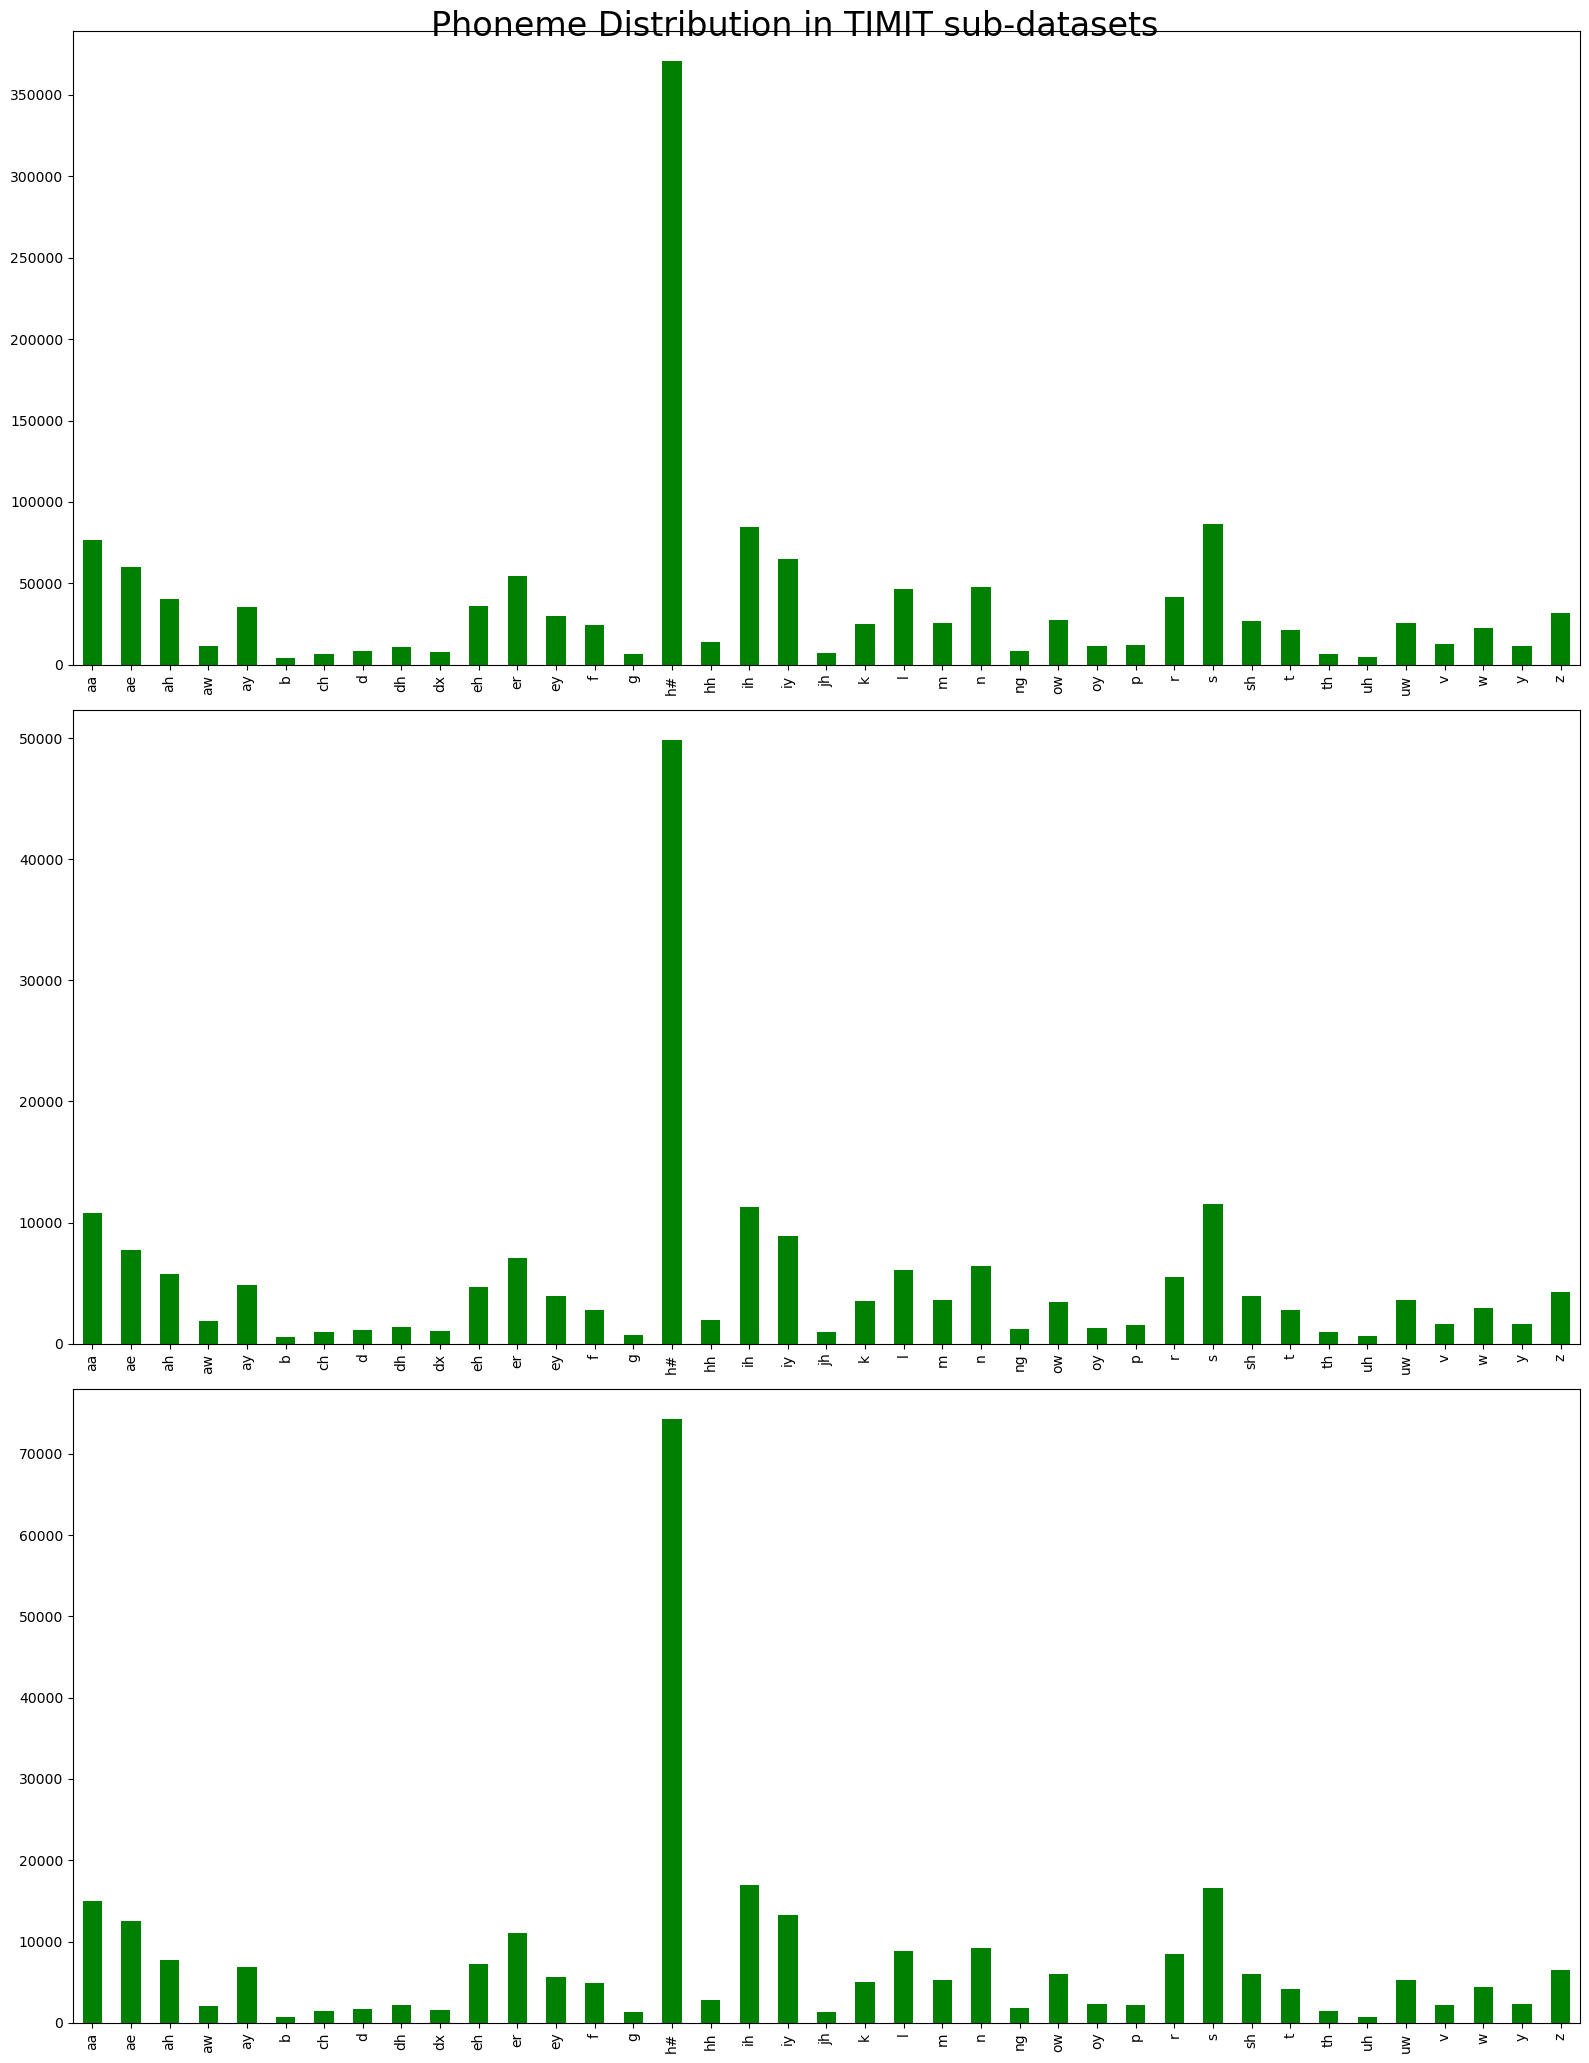

In [27]:
train_phoneme_counter=phoneme_count(train_df)
val_phoneme_counter=phoneme_count(val_df)
test_phoneme_counter=phoneme_count(test_df)

fig, (ax, bx, cx)=plt.subplots(nrows=3, figsize=(16, 21))

train_phoneme_counter.plot(kind='bar', color='green', ax=ax)
val_phoneme_counter.plot(kind='bar', color='green', ax=bx)
test_phoneme_counter.plot(kind='bar', color='green', ax=cx)


#plt.xticks(fontsize=20, rotation=90)
#plt.yticks(fontsize=18)
plt.suptitle('Phoneme Distribution in TIMIT sub-datasets', fontsize=24)
plt.tight_layout()
plt.plot()

[]

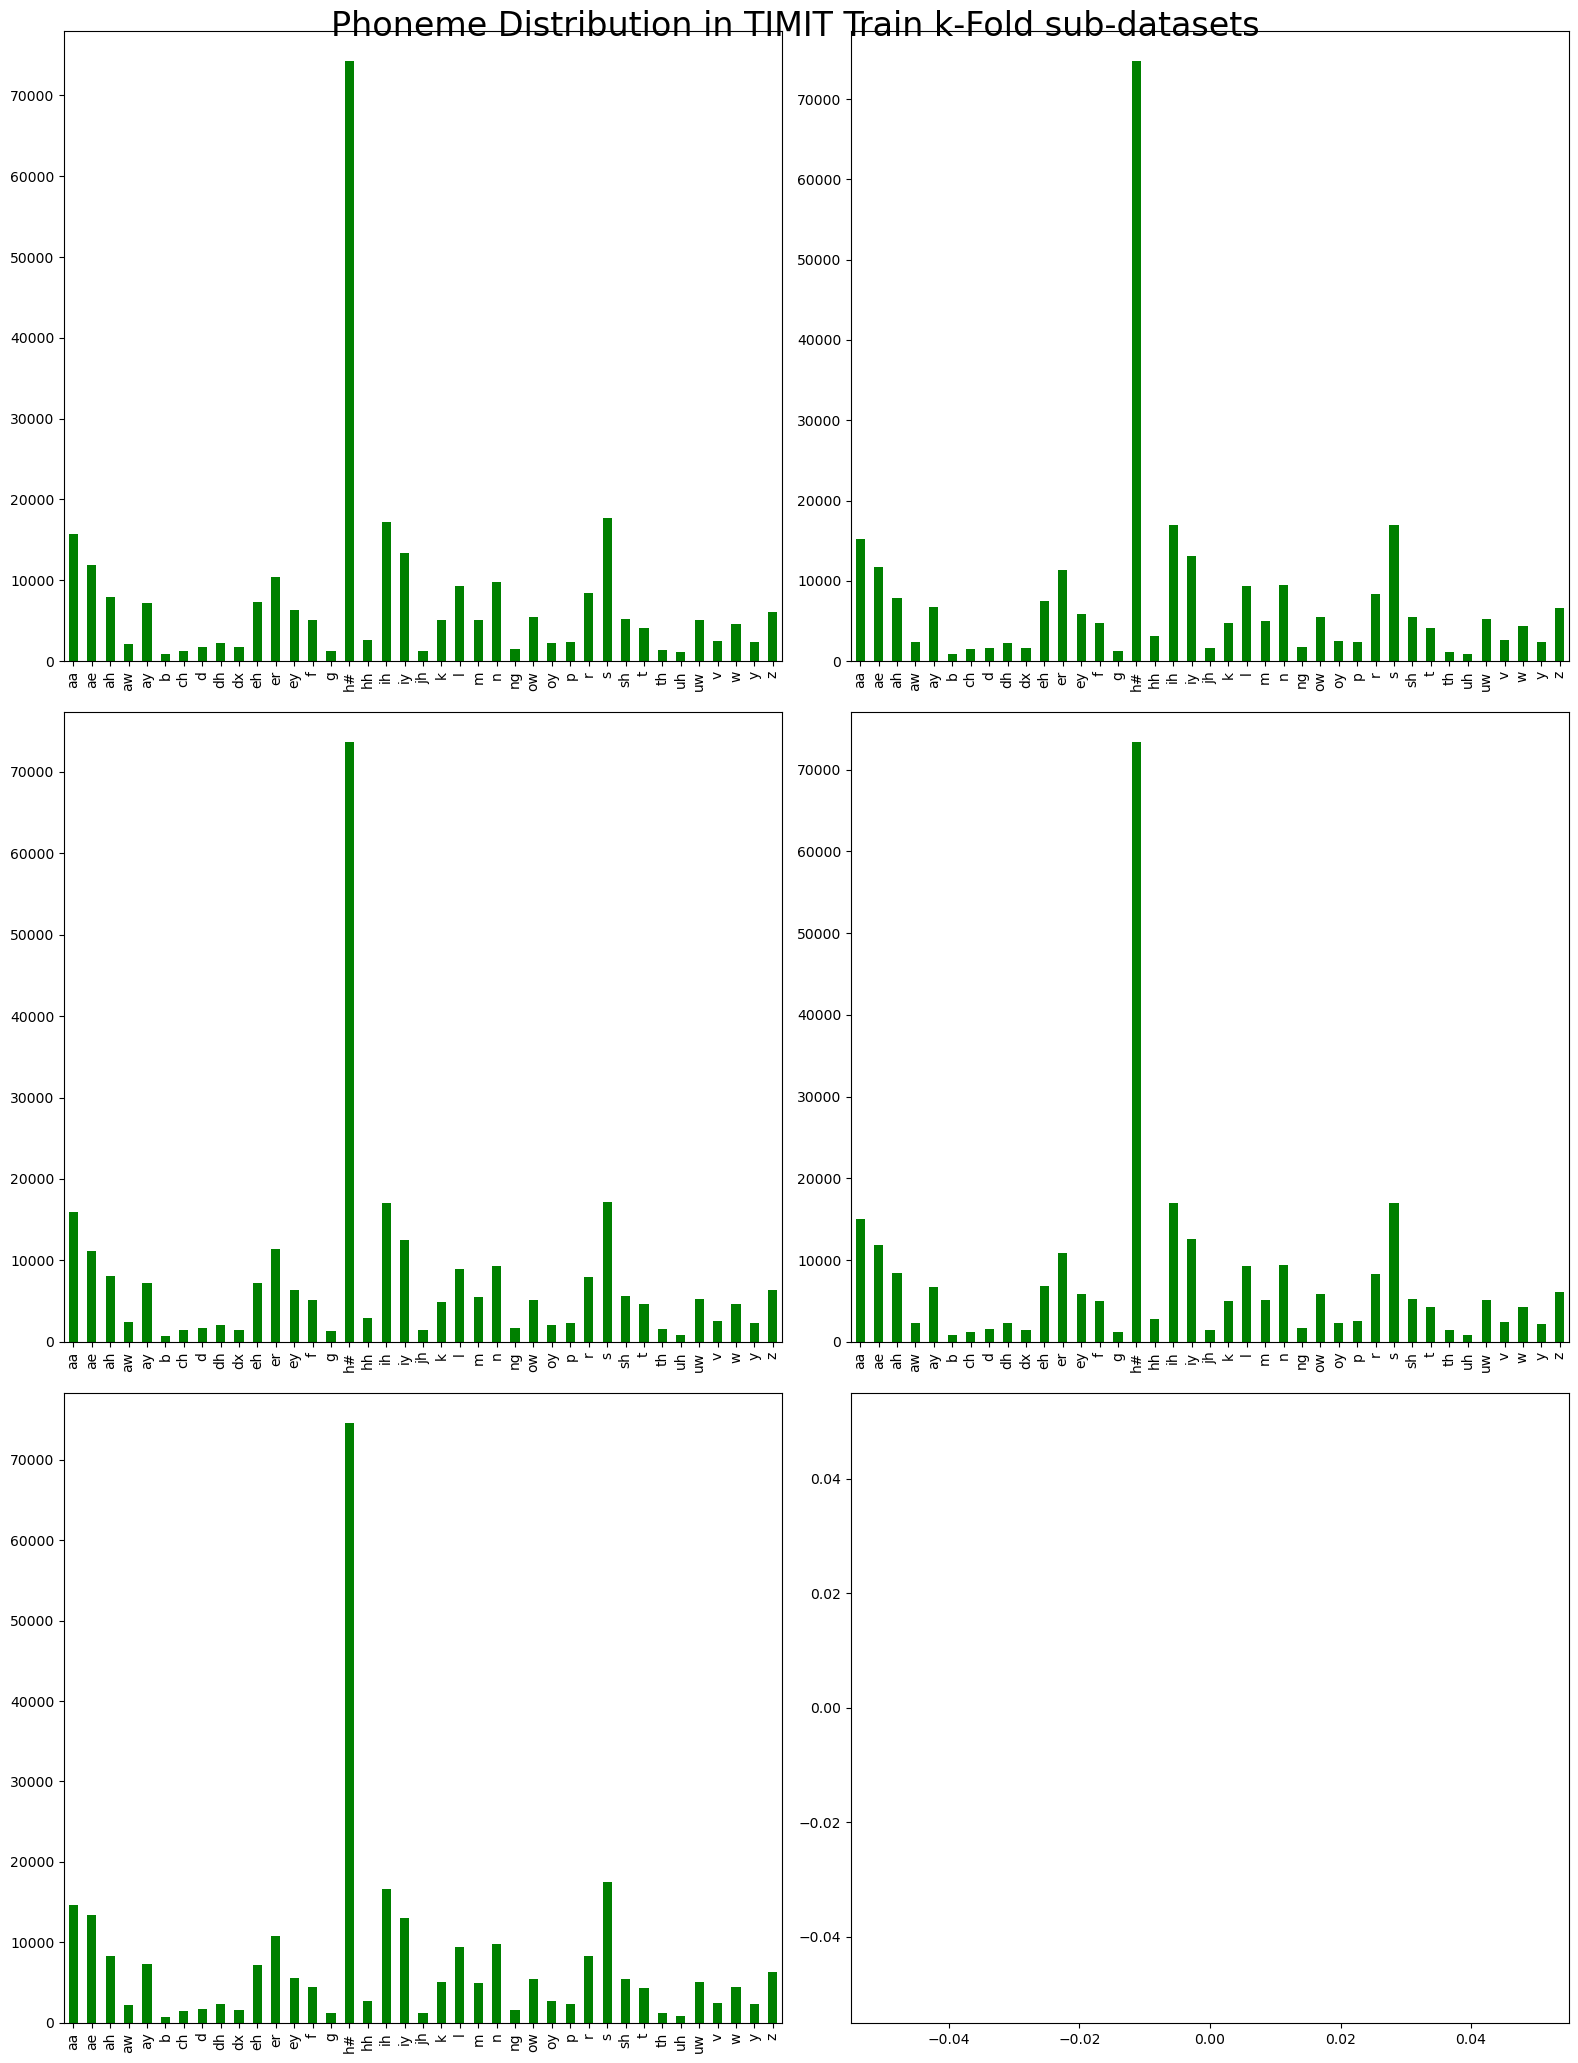

In [28]:
k1_train_phoneme_counter=phoneme_count(train_df[train_df['kfold']== f"fold{0+1}"])
k2_train_phoneme_counter=phoneme_count(train_df[train_df['kfold']== f"fold{1+1}"])
k3_train_phoneme_counter=phoneme_count(train_df[train_df['kfold']== f"fold{2+1}"])
k4_train_phoneme_counter=phoneme_count(train_df[train_df['kfold']== f"fold{3+1}"])
k5_train_phoneme_counter=phoneme_count(train_df[train_df['kfold']== f"fold{4+1}"])

fig, ((ax, bx), (cx, dx), (ex, _))=plt.subplots(nrows=3, ncols=2, figsize=(16, 21))

k1_train_phoneme_counter.plot(kind='bar', color='green', ax=ax)
k2_train_phoneme_counter.plot(kind='bar', color='green', ax=bx)
k3_train_phoneme_counter.plot(kind='bar', color='green', ax=cx)
k4_train_phoneme_counter.plot(kind='bar', color='green', ax=dx)
k5_train_phoneme_counter.plot(kind='bar', color='green', ax=ex)



#plt.xticks(fontsize=20, rotation=90)
#plt.yticks(fontsize=18)
plt.suptitle('Phoneme Distribution in TIMIT Train k-Fold sub-datasets', fontsize=24)
plt.tight_layout()
plt.plot()